### NDF: GGX(Trowbridge-Reitz)

$$
    D(m) = \frac{\alpha^2}{\pi ((n\cdot m)^2 (\alpha^2 - 1) + 1)^2}
$$

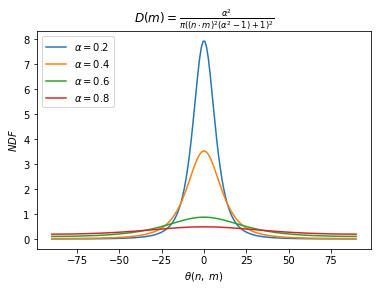

In [2]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)


def GGX_NDF(theta_m, alpha):
    theta_m = np.deg2rad(theta_m)
    cos_theta = np.maximum(0, np.cos(theta_m))
    alpha2 = alpha ** 2
    return alpha2 / np.pi / np.power(cos_theta ** 2 * (alpha2 - 1) + 1, 2)


theta = np.linspace(-90, 90, 180)
alpha1, alpha2, alpha3, alpha4 = 0.2, 0.3, 0.6, 0.8

ax.plot(theta, GGX_NDF(theta, alpha1), label=r"$\alpha=0.2$")
ax.plot(theta, GGX_NDF(theta, alpha2), label=r"$\alpha=0.4$")
ax.plot(theta, GGX_NDF(theta, alpha3), label=r"$\alpha=0.6$")
ax.plot(theta, GGX_NDF(theta, alpha4), label=r"$\alpha=0.8$")

ax.set_title(
    r"$D(m) = \frac{\alpha^2}{\pi ((n\cdot m)^2 (\alpha^2 - 1) + 1)^2}$")
ax.set_xlabel(r"$\theta(n,\ m)$")
ax.set_ylabel(r"$NDF$")
plt.legend(loc='upper left')


### Geometry: Smith, Schlick-GGX

Schlick-GGX 的 G 函数，其中 $k = \frac{\alpha}{2}$:

$$
    G_1(v) = \frac{n \cdot v}{(n \cdot v)(1 - k) + k}
$$

Smitch 给出的完整的 G 函数：
$$
    G(l,\ v,\ h) = G_1(l) \cdot G_1(v)
$$

示意图为：

<img src="./img/vector-tangent-space.png" alt="vector-tangent-space.png" width=450 />

从下图得到的结论是：$\theta_v$ 越小（垂直于平面进行观察），粗糙度越低，则 G 函数的值越小

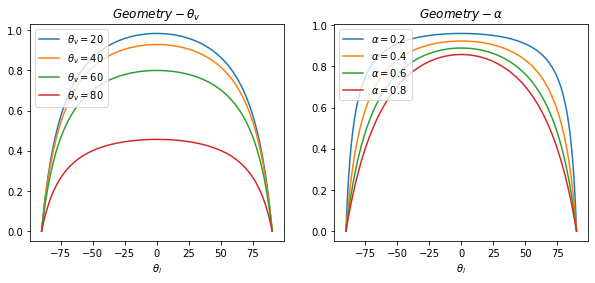

In [3]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


def GGX_G(theta, alpha):
    k = alpha / 2
    cos_theta = np.maximum(0, np.cos(np.deg2rad(theta)))
    return cos_theta / (cos_theta * (1 - k) + k)


def Smith_G(theta_l, theta_v, alpha):
    return GGX_G(theta_l, alpha) * GGX_G(theta_v, alpha)


theta_l = np.linspace(-90, 90, 180)

# 和观察方向的关系
ax1.set_title(r"$Geometry - \theta_v$")
ax1.plot(theta_l, Smith_G(-20, theta_l, 0.5), label=r"$\theta_v = 20$")
ax1.plot(theta_l, Smith_G(-40, theta_l, 0.5), label=r"$\theta_v = 40$")
ax1.plot(theta_l, Smith_G(-60, theta_l, 0.5), label=r"$\theta_v = 60$")
ax1.plot(theta_l, Smith_G(-80, theta_l, 0.5), label=r"$\theta_v = 80$")
ax1.set_xlabel(r"$\theta_l$")
ax1.legend(loc='upper left')

# 和粗糙度的关系
ax2.set_title(r"$Geometry - \alpha$")
ax2.plot(theta_l, Smith_G(-45, theta_l, 0.2), label=r"$\alpha = 0.2$")
ax2.plot(theta_l, Smith_G(-45, theta_l, 0.4), label=r"$\alpha = 0.4$")
ax2.plot(theta_l, Smith_G(-45, theta_l, 0.6), label=r"$\alpha = 0.6$")
ax2.plot(theta_l, Smith_G(-45, theta_l, 0.8), label=r"$\alpha = 0.8$")
ax2.set_xlabel(r"$\theta_l$")
ax2.legend(loc='upper left')


### Fresnel-Schlick

参考 Fresnel 那个笔记

$$
    F(v,\ h) = F_0 + (1 - F_0)(1 - (v \cdot h))^5
$$

In [64]:
def Fresnel_Schlick(F0, theta_v_h):
    """接收基础反射系数和入射角度值"""
    theta = np.deg2rad(theta_v_h)
    cos_theta = np.maximum(0, np.cos(theta))
    return F0 + np.power((1 - F0) * (1 - cos_theta), 5.0)

### BRDF-GGX

将 BRDF 带入反射方程，展开可得：

$$
    L_o(v) = \frac{1}{4|n \cdot v|} \int_{\Omega} L_i(l)\ D(h)\ F(v,\ h)\ G(v,\ l) d\omega_l
$$

从下图可以看出：
- DFG 的形状主要和粗糙度有关
- DFG 的形状主要来自于「法线分布函数」

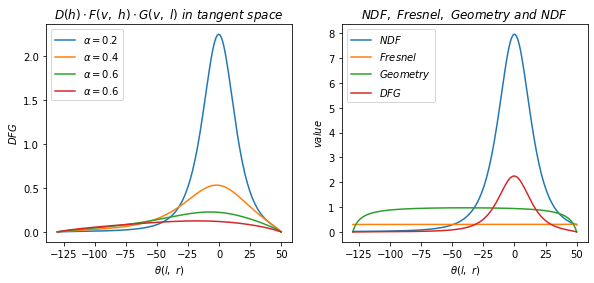

In [83]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

F0 = 0.3
theta_v = -40.0
theta_r = 40.0

theta_l = np.linspace(-90, 90, 180)
theta_h = (theta_v + theta_l) / 2.0
theta_v_h = theta_v - theta_h
theta_l_r = theta_l - theta_r


def fr_part(alpha):
    D = GGX_NDF(theta_h, alpha)
    F = Fresnel_Schlick(F0, np.abs(theta_v_h))
    G = Smith_G(theta_l, theta_v, alpha)
    return D * F * G


ax1.plot(theta_l_r, fr_part(0.2), label=r"$\alpha = 0.2$")
ax1.plot(theta_l_r, fr_part(0.4), label=r"$\alpha = 0.4$")
ax1.plot(theta_l_r, fr_part(0.6), label=r"$\alpha = 0.6$")
ax1.plot(theta_l_r, fr_part(0.8), label=r"$\alpha = 0.6$")
ax1.set_xlabel(r"$\theta(l,\ r)$")
ax1.set_ylabel(r"$DFG$")
ax1.set_title(r"$D(h)\cdot F(v,\ h)\cdot G(v,\ l)\ in\ tangent\ space$")
ax1.legend(loc="upper left")

ax2.plot(theta_l_r, GGX_NDF(theta_h, 0.2), label=r"$NDF$")
ax2.plot(theta_l_r, Fresnel_Schlick(F0, np.abs(theta_v_h)), label=r"$Fresnel$")
ax2.plot(theta_l_r, Smith_G(theta_l, theta_v, 0.2), label=r"$Geometry$")
ax2.plot(theta_l_r, fr_part(0.2), label=r"$DFG$")
ax2.set_xlabel(r"$\theta(l,\ r)$")
ax2.set_ylabel(r"$value$")
ax2.set_title(r"$NDF,\ Fresnel,\ Geometry\ and\ NDF$")
ax2.legend(loc="upper left")


### 反射波瓣的图像

反射波瓣的图像可以参考旁边的 python 绘图脚本